<a href="https://colab.research.google.com/github/EsserMishelle/customer-spending-segmentation/blob/main/3_Clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Clustering
## This notebook applies the finalized preprocessing and clustering parameters to assign customers to their respective segments.

In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA

from scipy.cluster.hierarchy import dendrogram, linkage, fcluster

np.random.seed(42)

In [4]:
# Load the dataset
df = pd.read_csv('https://raw.githubusercontent.com/sik-flow/new_data1/refs/heads/main/Wholesale%20customers%20data.csv')
df_raw = df.copy() # for reference

## Data Preprocessing (for Clustering)

In [5]:
# Reusing spending variables identified during EDA
spend_cols = ['Fresh', 'Milk', 'Grocery', 'Frozen', 'Detergents_Paper', 'Delicassen' ]

X = df[spend_cols]

## Tranformation (Log)

Because spending data is heavily right-skewed with extreme values, a log1p transformation is applied to reduce the influence of very large expenditures before clustering.

In [6]:
X_log = np.log1p(X)

## Scaling

In [7]:
from sklearn.preprocessing import StandardScaler

ss = StandardScaler()
X_scaled = ss.fit_transform(X_log)

### PCA with chosen components

In [14]:
pca = PCA(n_components=3)
X_pca = pca.fit_transform(X_scaled)

## Fit the Final Clustering
### K-Means with K=3 on 3 pca components


In [15]:
km = KMeans(n_clusters=3, random_state=42, n_init=10) # Added n_init=10 to suppress future warnings
cluster_labels = km.fit_predict(X_pca)

df['Cluster'] = cluster_labels

## Final metrics

In [17]:
sil_score = silhouette_score(X_pca, cluster_labels)

print(f"Silhouette Score: {sil_score:.2f}")

Silhouette Score: 0.33


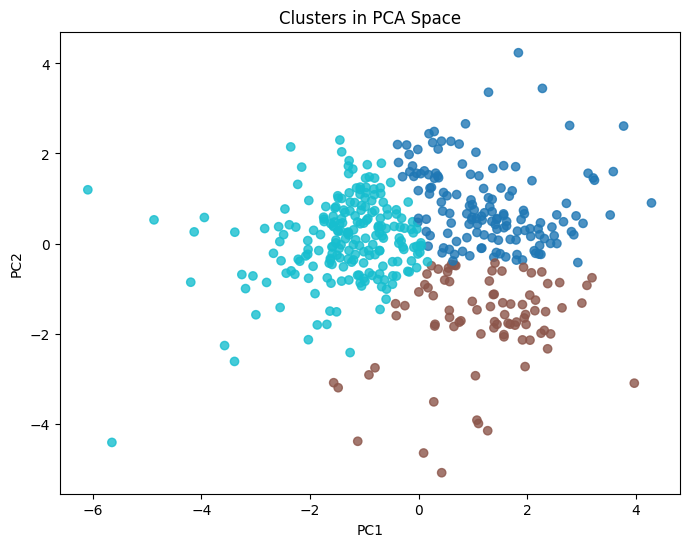

In [20]:
plt.figure(figsize=(8,6))
plt.scatter(X_pca[:,0], X_pca[:,1], c=cluster_labels, cmap='tab10', alpha=0.8)
plt.title("Clusters in PCA Space")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()